In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import trange

%matplotlib inline
from matplotlib import pyplot as plt

def plot(src, cmap=None, title=None, size=(10, 10)):
    plt.rcParams['figure.figsize'] = size
    plt.imshow(src, cmap)
    plt.title(title)
    plt.axis("off")

In [3]:
from infrastructure.interface import DetectionData, ClassificationData
from service.interface import FrameData
from service.recognition import RecognitionService
from service.drawing import DrawingService

from infrastructure.detection import YOLODetector

### Init models

In [4]:
detector = YOLODetector(
    model_path='../detector.pt', conf_thresh=0.6, device="cuda:0"
)
rec_service = RecognitionService(detector, None)
draw_service = DrawingService()

In [5]:
import os
video_path = '../cv_training/detector_training/datasets/construction_analytics/videos/output118.mp4'
frame_data_list = rec_service.process_video(video_path)

In [6]:
draw_service.process_video(video_path, frame_data_list)

  0%|          | 0/359 [00:00<?, ?it/s]

100%|██████████| 359/359 [00:10<00:00, 35.32it/s]


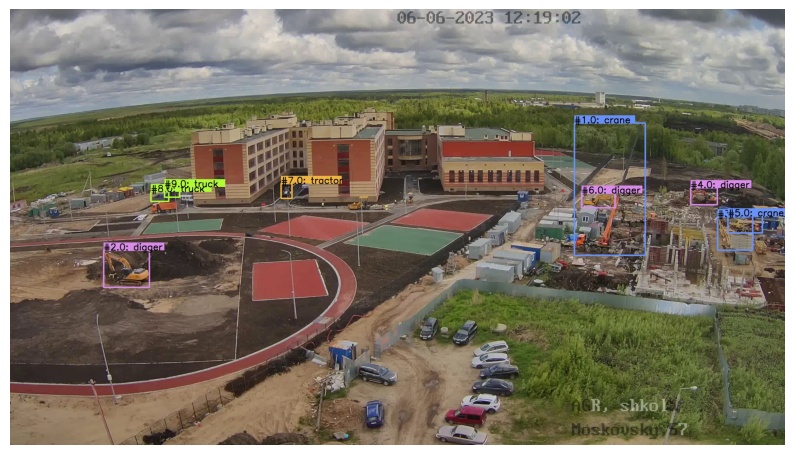

In [7]:
cap = cv2.VideoCapture(f"output/{os.path.basename(video_path)}")
_, frame = cap.read()
plot(frame[..., ::-1])

In [9]:
n_frames = len(frame_data_list)
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
print("FPS:", fps)
frame_to_timestamp = {}
for frame_num in range(n_frames):
    secs = frame_num // fps
    minutes = secs // 60
    secs %= 60    
    frame_to_timestamp[frame_num] = f"{minutes}m {secs}s"

FPS: 5


In [10]:
result = [] # list of tracks
"""
result = [
    {
        "track_id": ...
        "class":
        "start":
        "end":   
    }
]
"""
def get_unique_track_ids(frame_data_list):
    track_ids = set()
    for frame_data in frame_data_list:
        for det in frame_data.detections:
            track_ids.add(int(det.tracking_id))
    return track_ids


unique_tracks = get_unique_track_ids(frame_data_list)
result = [
    {
        "id": track_id, 
        "class": None,
        "start": None,
        "end": None,
    }
    for track_id in unique_tracks
]
track2idx = {
    track: i
    for i, track in enumerate(unique_tracks)
}
for frame_num, frame_data in enumerate(frame_data_list):
    for det in frame_data.detections:
        track_id = int(det.tracking_id)
        result[track2idx[track_id]]["class"] = det.class_name
        if result[track2idx[track_id]]["start"] is None:
            result[track2idx[track_id]]["start"] = frame_to_timestamp[frame_num]
        result[track2idx[track_id]]["end"] = frame_to_timestamp[frame_num]

In [12]:
import json
with open(f"output/{os.path.basename(video_path)[:-4]}.json", "w") as f:
    json.dump(result, f)

In [13]:
result

[{'id': 1, 'class': 'crane', 'start': '0m 0s', 'end': '1m 11s'},
 {'id': 2, 'class': 'digger', 'start': '0m 0s', 'end': '1m 11s'},
 {'id': 3, 'class': 'crane', 'start': '0m 0s', 'end': '1m 11s'},
 {'id': 4, 'class': 'digger', 'start': '0m 0s', 'end': '1m 11s'},
 {'id': 5, 'class': 'crane', 'start': '0m 0s', 'end': '1m 11s'},
 {'id': 6, 'class': 'digger', 'start': '0m 0s', 'end': '1m 11s'},
 {'id': 7, 'class': 'tractor', 'start': '0m 0s', 'end': '1m 11s'},
 {'id': 8, 'class': 'truck', 'start': '0m 0s', 'end': '1m 11s'},
 {'id': 9, 'class': 'truck', 'start': '0m 0s', 'end': '1m 11s'},
 {'id': 10, 'class': 'truck', 'start': '0m 0s', 'end': '1m 11s'}]